In [1]:
import h5py
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import tensorflow as tf
from tqdm.notebook import tqdm
import gwpy
from gwpy.timeseries import TimeSeries
# tf.config.experimental.set_memory_growth()

In [2]:
INPUT_FILE = "../input/synthetic-h5/train_300_3.h5"

In [3]:
with h5py.File(INPUT_FILE, "r") as f:
    injection_shape = f["injection_samples"]["h1_strain"].shape
    noise_shape = f["noise_samples"]["h1_strain"].shape
    
    injections_h1 = np.array(f["injection_samples"]["h1_strain"])
    ground_truths_h1 = np.array(f["injection_parameters"]["h1_signal"])
    noise_h1 = np.array(f["noise_samples"]["h1_strain"])
    
    injections_l1 = np.array(f["injection_samples"]["l1_strain"])
    ground_truths_l1 = np.array(f["injection_parameters"]["l1_signal"])
    noise_l1 = np.array(f["noise_samples"]["l1_strain"])
    
    injections_v1 = np.array(f["injection_samples"]["v1_strain"])
    noise_v1 = np.array(f["noise_samples"]["v1_strain"])
    ground_truths_v1 = np.array(f["injection_parameters"]["v1_signal"])
    

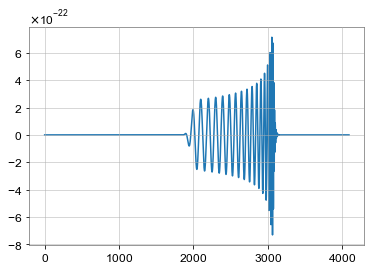

In [4]:
with h5py.File(INPUT_FILE, "r") as f:
    g_t = f["injection_parameters"]["h1_signal"][16]
plt.plot(g_t)


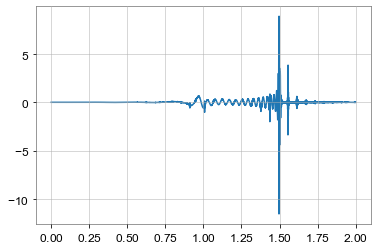

In [5]:
gt = TimeSeries(g_t, sample_rate=2048)
gt = gt.whiten(0.5,0.25)
plt.plot(gt)

In [6]:
if injection_shape[1] == noise_shape[1]:
    ds_shape = (injection_shape[0] + noise_shape[0], injection_shape[1],3)
    targets = np.zeros(ds_shape[0], dtype=np.uint8)
    timeseries = np.zeros(ds_shape)
    ground_truths = np.zeros(ds_shape)
    targets[:injection_shape[0]] = 1
    targets[injection_shape[0]:] = 0
    timeseries[:injection_shape[0],:,0] = injections_h1
    timeseries[injection_shape[0]:,:,0] = noise_h1
    ground_truths[:injection_shape[0],:,0] = ground_truths_h1
    timeseries[:injection_shape[0],:,1] = injections_l1
    timeseries[injection_shape[0]:,:,1] = noise_l1
    ground_truths[:injection_shape[0],:,1] = ground_truths_l1
    timeseries[:injection_shape[0],:,2] = injections_v1
    timeseries[injection_shape[0]:,:,2] = noise_v1
    ground_truths[:injection_shape[0],:,2] = ground_truths_v1
    
    
for i in tqdm(range(timeseries.shape[0])):
    timeseries[i] /= abs(timeseries[i]).max()

    

  0%|          | 0/100000 [00:00<?, ?it/s]

In [7]:
# for i in tqdm(range(injection_shape[0])):
#     for j in range(ground_truths.shape[2]):
#         gt = TimeSeries(ground_truths[i,:,j], sample_rate=2048)
#         gt = gt.whiten(0.5,0.25)
#         ground_truths[i,:,j] = gt
for i in tqdm(range(injection_shape[0])):
    ground_truths[i] /= abs(ground_truths[i]).max()

  0%|          | 0/50000 [00:00<?, ?it/s]

In [8]:
batches = 8
batch_size = timeseries.shape[0] // batches
indices = np.arange(targets.shape[0])
np.random.shuffle(indices)
for i in tqdm(range(batches)):
    rg_n = range(i*batch_size,(i+1)*batch_size)
    inds = indices[rg_n]
    output_file = f"../input/synthetic-tfrec/{INPUT_FILE.split('/')[-1].replace('.h5','')}_{batch_size}_{i:02}.tfrec"
    writer = tf.io.TFRecordWriter(output_file)
    
    for j in tqdm(range(inds.shape[0])):
        X = timeseries[inds[j]]
        y = targets[inds[j]]
        y1 = ground_truths[inds[j]]
        feature={}
        feature["TimeSeries"] = tf.train.Feature(float_list=tf.train.FloatList(value=X.flatten()))
        feature["GroundTruths"] = tf.train.Feature(float_list=tf.train.FloatList(value=y1.flatten()))
        feature["Target"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[y]))

        example = tf.train.Example(features=tf.train.Features(feature=feature))
        serialized = example.SerializeToString()
        writer.write(serialized)
    writer.close()      


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]